<h1>Notebook to plot some general clustering information</h1>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
basedir = '/Users/joewandy/git/metabolomics_tools'
sys.path.append(basedir)

In [3]:
import numpy as np
import pylab as plt
import pandas as pd
from scipy.stats import ttest_rel

import seaborn as sns
sns.set(color_codes=True)
from IPython.display import display, HTML

import cPickle
import random
import copy
import glob
import gzip
import string

In [4]:
from alignment.models import HyperPars as AlignmentHyperPars
from alignment.experiment import *
from efcompute.ef_assigner import ef_assigner

In [5]:
input_dir = '/Users/joewandy/git/metabolomics_tools/alignment/input/std1_csv_full_old'
transformation_file = '/Users/joewandy/git/metabolomics_tools/alignment/pos_transformations_full.yml'
gt_file = '/Users/joewandy/git/metabolomics_tools/alignment/input/std1_csv_full_old/ground_truth/ground_truth.txt'

In [6]:
hp = AlignmentHyperPars()    
hp.within_file_mass_tol = 5
hp.within_file_rt_tol = 30
hp.across_file_mass_tol = 10
hp.across_file_rt_tol = 60
hp.alpha_mass = 1.0
hp.dp_alpha = 1000.0
hp.beta = 0.1
hp.t = 0.0
hp.mass_clustering_n_iterations = 5000
hp.rt_clustering_nsamps = 500
hp.rt_clustering_burnin = 0

print hp

Hyperparameters across_file_mass_tol=10, across_file_rt_tol=60, alpha_mass=1.0, beta=0.1, dp_alpha=1000.0, mass_clustering_n_iterations=5000, matching_alpha=0.3, rt_clustering_burnin=0, rt_clustering_nsamps=500, second_stage_clustering_use_adduct_likelihood=True, second_stage_clustering_use_mass_likelihood=True, second_stage_clustering_use_rt_likelihood=True, t=0.0, within_file_mass_tol=5, within_file_rt_tol=30


<h1>1. Load the data</h1>

In [7]:
# combined_list = load_or_create_clustering('pickles/std1_pos_clustering.p', input_dir, transformation_file, hp)
# print "Loaded %s" % [x[0].filename for x in combined_list]

In [8]:
# selected_files = [x[0] for x in combined_list]  
# selected_clusterings = [x[1] for x in combined_list]            
# aligner_std = Aligner(selected_files, None, transformation_file, hp, verbose=False, seed=1234567890)
# match_mode = 1
# aligner_std.run(match_mode, first_stage_clustering_results=selected_clusterings)

In [9]:
clustering_out = 'pickles/cm_all_standards.p'

In [10]:
# with gzip.GzipFile(clustering_out, 'wb') as f:
#     cPickle.dump(aligner, f, protocol=cPickle.HIGHEST_PROTOCOL)                    
# print "Saved clustering to %s" % clustering_out

In [11]:
def print_peak_stats(aligner):
    data_list = aligner.data_list
    hp = aligner.hp
    total_peaks = 0
    for f in range(len(data_list)):
        data = data_list[f]
        count = len(data.features)
        print "%d peaks in file %d" % (count, f)
        total_peaks += count
        intensities = [peak.intensity for peak in data.features]
        mi = min(intensities)
        print 'min intensity %f in file %d' % (mi, f)
    print "total peaks %d" % total_peaks

In [12]:
aligner_std = load_clustering(clustering_out)

Loaded from pickles/cm_all_standards.p


In [13]:
print_peak_stats(aligner_std)

4999 peaks in file 0
min intensity 1115.132812 in file 0
4986 peaks in file 1
min intensity 1150.603638 in file 1
6836 peaks in file 2
min intensity 1008.037781 in file 2
9752 peaks in file 3
min intensity 1056.940552 in file 3
7076 peaks in file 4
min intensity 1110.571045 in file 4
4146 peaks in file 5
min intensity 1224.057251 in file 5
6319 peaks in file 6
min intensity 1050.191528 in file 6
4101 peaks in file 7
min intensity 1538.965698 in file 7
5485 peaks in file 8
min intensity 1125.571167 in file 8
5034 peaks in file 9
min intensity 1135.189575 in file 9
5317 peaks in file 10
min intensity 1041.965210 in file 10
total peaks 64051


Load beer

In [14]:
aligner_beer = load_clustering('pickles/beer3pos/cc.p')

Loaded from pickles/beer3pos/cc.p


In [15]:
print_peak_stats(aligner_beer)

7553 peaks in file 0
min intensity 7446.578613 in file 0
7579 peaks in file 1
min intensity 6818.049805 in file 1
7240 peaks in file 2
min intensity 8247.436523 in file 2
total peaks 22372


<h1>2. Plot some general statistics</h1>

In [16]:
def plot_cluster_size(acs, prefix):
    min_intensity = 520000
    print 'min_intensity = %.2e' % min_intensity
    size_rows = []
    singleton_rows = []
    for f in range(len(acs)):

        ac = acs[f]
        singleton_count = 0
        non_singleton_count = 0
        filtered_singleton_count = 0
        filtered_non_singleton_count = 0
        
        for cluster in ac.clusters:

            n_member = len(cluster.members)
            if n_member == 0:
                # skip empty cluster
                continue
            if n_member == 1:
                # count singleton
                singleton_count += 1                
                # count singleton above intensity threshold
                peak, ac = cluster.members[0]
                if peak.intensity > min_intensity:
                    filtered_singleton_count += 1
            else:
                # count the non-singleton cluster
                non_singleton_count += 1
                # count the non-singleton cluster with all members above intensity threshold
                member_count = 0
                for peak, ac in cluster.members:
                    if peak.intensity > min_intensity:
                        member_count += 1
                if member_count == 1:
                    filtered_singleton_count += 1
                elif member_count > 1:
                    filtered_non_singleton_count += 1
                
            # for the plotting
            filename = '%s %02d' % (prefix, f+1)
            size_rows.append((filename, cluster.id, len(cluster.members)))
    
        ratio = float(non_singleton_count)/(non_singleton_count+singleton_count) * 100
        filtered_ratio = float(filtered_non_singleton_count)/(filtered_non_singleton_count+filtered_singleton_count) * 100
        singleton_rows.append((filename, 
                               singleton_count, non_singleton_count, ratio, 
                               filtered_singleton_count, filtered_non_singleton_count, filtered_ratio))

    df = pd.DataFrame(size_rows, columns=['std_file', 'cluster', 'cluster_size'])
    fig = plt.figure(figsize=(12, 6))    
    sns.countplot(x='cluster_size', hue='std_file', data=df.sort_values(by=['cluster_size', 'std_file']))
    fig.get_axes()[0].legend(loc='upper right')    
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor('white')    
    plt.tight_layout()
    if prefix.lower() == 'std':
        prefix = 'Standard'    
    plt.title('Cluster Sizes (%s)' % prefix, fontsize=32)
    plt.savefig('figures/counts_cluster_%s.pdf' % prefix)

    df = pd.DataFrame(singleton_rows, columns=['std_file', 
                                               'singleton', 
                                               'non-singleton', 
                                               '(non-singleton/singleton)%',
                                               'filtered singleton', 
                                               'filtered non-singleton',  
                                               'filtered (non-singleton/singleton)%'
                                              ])
    display(df)

In [17]:
def plot_trans(acs, prefix, exclude_MH=True, size=4, aspect=1, plot=1):

    rows = []
    mh_count = 0
    non_mh_count = 0
    for f in range(len(acs)):
        ac = acs[f]
        for cluster in ac.clusters:
            for peak, poss in cluster.members:
                fn = '%s %02d' % (prefix, peak.file_id+1)
                if 'M+H' in poss.transformation.name:
                    mh_count += 1
                else:
                    non_mh_count += 1
                if not exclude_MH:
                    rows.append((cluster.id, peak.feature_id, fn, peak.mass, peak.rt, peak.intensity,
                                 poss.transformation.name, poss.transformed_mass, poss.prob))
                elif 'M+H' not in poss.transformation.name:
                    rows.append((cluster.id, peak.feature_id, fn, peak.mass, peak.rt, peak.intensity,
                                 poss.transformation.name, poss.transformed_mass, poss.prob))
                
    df = pd.DataFrame(rows, columns=["clusterID", "peakID", "std_file", "mass", "RT", "intensity", "transformation", "trans_mass", "probability"])  
    temp = df['transformation'].values
    ordering = sorted(list(set(temp.tolist())))    
    if prefix.lower() == 'std':
        prefix = 'Standard'

    if plot == 1: # plot trans counts
    
        fig = plt.figure()
        g = sns.factorplot(y='transformation', hue='std_file', data=df, order=ordering, 
                           kind='count', size=size, aspect=aspect, legend=False)
        legend = plt.legend(loc='upper right', frameon=True)
        frame = legend.get_frame()
        frame.set_facecolor('white')    
        plt.title('A. Transformation Types (%s)' % prefix, fontsize=48)
        plt.tight_layout()
        plt.savefig('figures/counts_trans_%s.pdf' % prefix)
        print "Total peaks having M+H trans = %d" % mh_count
        print "Total peaks having non-M+H trans = %d" % non_mh_count        
        
    elif plot == 2: # plot trans probabilities
        
        plt.figure()
        sns.factorplot(y="transformation", x="probability", data=df, order=ordering, kind='box', 
                       size=size, aspect=aspect, color='c')
        plt.title('B. Transformation Probabilities (%s)' % prefix, fontsize=48)
        plt.tight_layout()
        plt.savefig('figures/prob_trans_%s.pdf' % prefix)
        
    return df

In [18]:
def plot_biggest(clustering_results, threshold, file_idx):

    ac = clustering_results[file_idx]
    clusters_list = ac.clusters
    singleton_count = 0

    big_clusters = []
    biggest = clusters_list[0]
    for cluster in clusters_list:
        if cluster.N == 1:
            singleton_count += 1
        if cluster.N >= threshold:
            big_clusters.append(cluster)
            if cluster.N >= biggest.N:
                biggest = cluster

    print "Singleton count {}".format(singleton_count)
    print "{} big clusters found".format(len(big_clusters))
    print "Biggest has {} members".format(biggest.N)
    file_idx += 1

    for c in big_clusters:
        ac.cluster_plot(c)

In [19]:
data_list = aligner_std.data_list
hp = aligner_std.hp
total_peaks = 0
for f in range(len(data_list)):
    data = data_list[f]
    count = len(data.features)
    print "%d peaks in file %d" % (count, f)
    total_peaks += count
print "total peaks %d" % total_peaks

4999 peaks in file 0
4986 peaks in file 1
6836 peaks in file 2
9752 peaks in file 3
7076 peaks in file 4
4146 peaks in file 5
6319 peaks in file 6
4101 peaks in file 7
5485 peaks in file 8
5034 peaks in file 9
5317 peaks in file 10
total peaks 64051


min_intensity = 5.20e+05


,std_file,singleton,non-singleton,(non-singleton/singleton)%,filtered singleton,filtered non-singleton,filtered (non-singleton/singleton)%
0,Std 01,4327,301,6.503889,229,15,6.147541
1,Std 02,4341,288,6.221646,211,13,5.803571
2,Std 03,5755,481,7.713278,149,8,5.095541
3,Std 04,8011,775,8.820851,290,18,5.844156
4,Std 05,5810,551,8.662160,284,23,7.491857
5,Std 06,3655,216,5.579954,244,13,5.058366
6,Std 07,5272,469,8.169308,261,22,7.773852
7,Std 08,3579,232,6.087641,288,9,3.030303
8,Std 09,4789,312,6.116448,269,15,5.281690
9,Std 10,4304,310,6.718682,176,13,6.878307


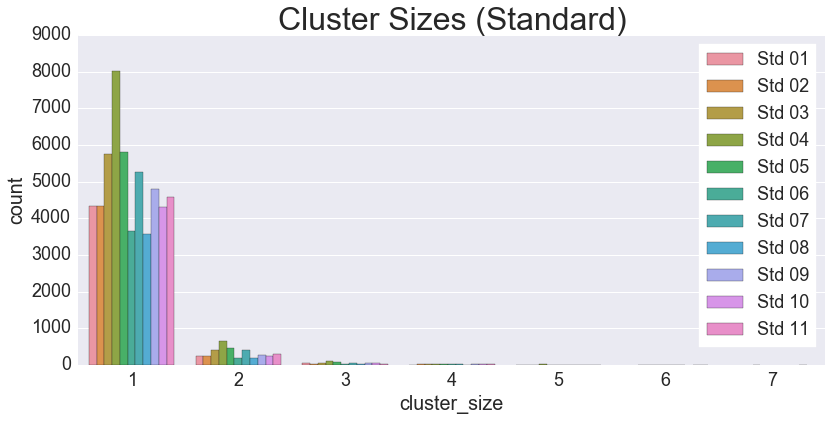

In [20]:
sns.set_context("notebook", font_scale=1.8)
plot_cluster_size(aligner_std.clustering_results, 'Std')

Total peaks having M+H trans = 59036
Total peaks having non-M+H trans = 5015


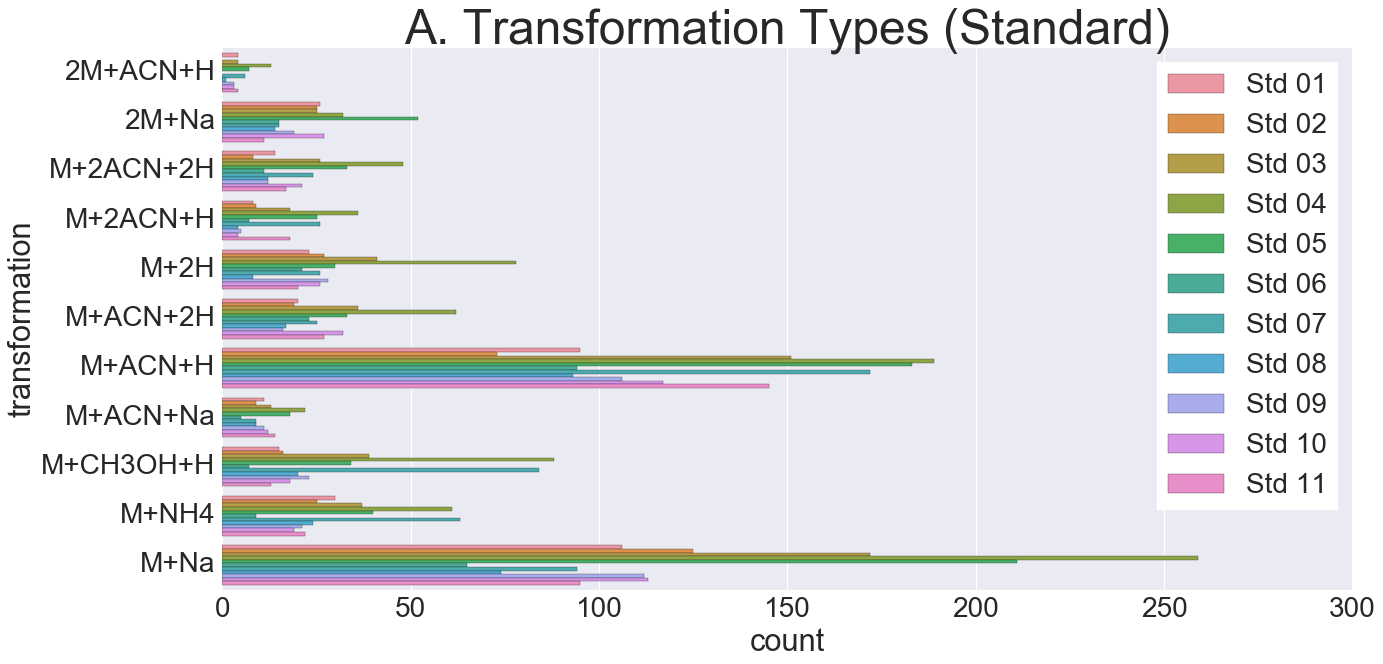

In [21]:
sns.set_context("notebook", font_scale=2.8)
df = plot_trans(aligner_std.clustering_results, 'Std', exclude_MH=True, size=10, aspect=2, plot=1)

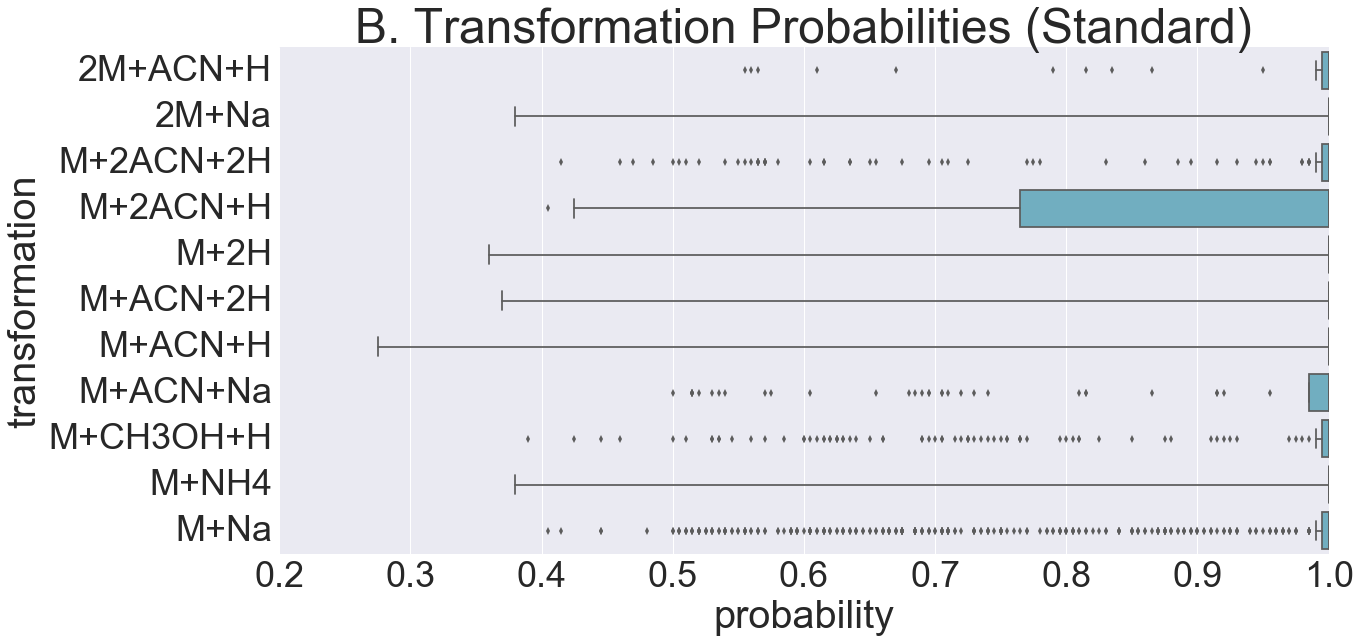

In [22]:
sns.set_context("notebook", font_scale=3.6)
df = plot_trans(aligner_std.clustering_results, 'Standard', exclude_MH=True, size=10, aspect=2, plot=2)

min_intensity = 5.20e+05


,std_file,singleton,non-singleton,(non-singleton/singleton)%,filtered singleton,filtered non-singleton,filtered (non-singleton/singleton)%
0,Beer 01,6179,633,9.292425,1962,197,9.124595
1,Beer 02,6203,631,9.233246,1979,200,9.178522
2,Beer 03,5983,574,8.754003,2129,214,9.133589


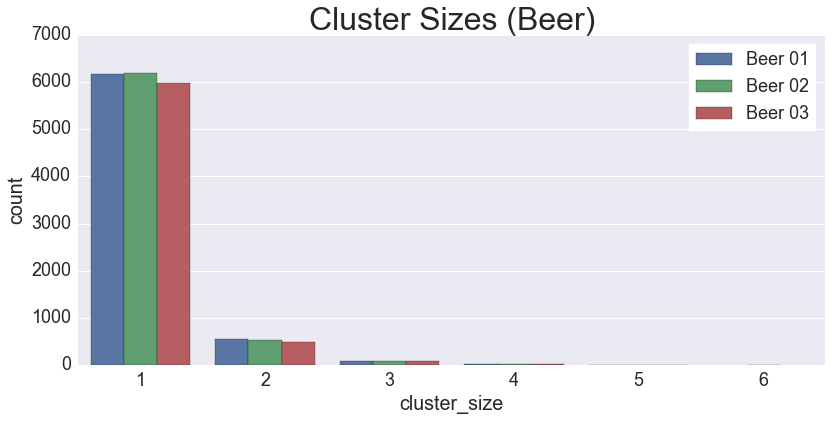

In [23]:
sns.set_context("notebook", font_scale=1.8)
plot_cluster_size(aligner_beer.clustering_results, 'Beer')

Total peaks having M+H trans = 20185
Total peaks having non-M+H trans = 2187


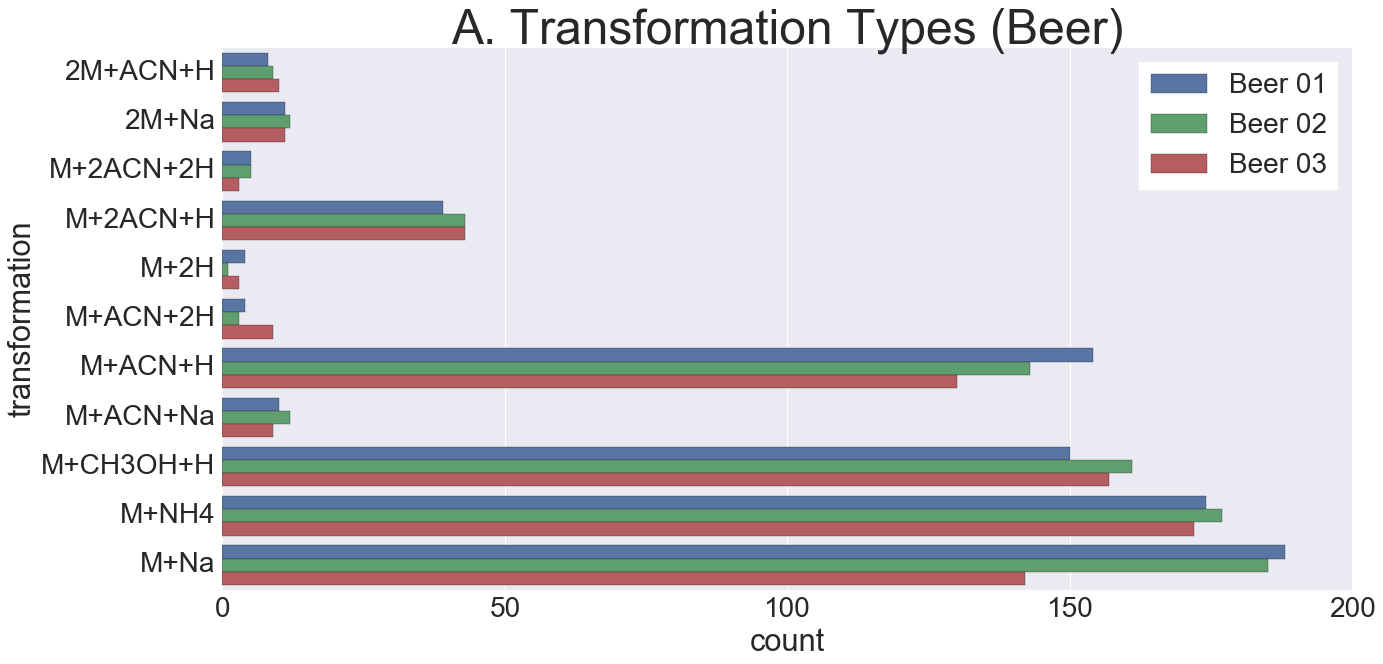

In [24]:
sns.set_context("notebook", font_scale=2.8)
df = plot_trans(aligner_beer.clustering_results, 'Beer', exclude_MH=True, size=10, aspect=2, plot=1)

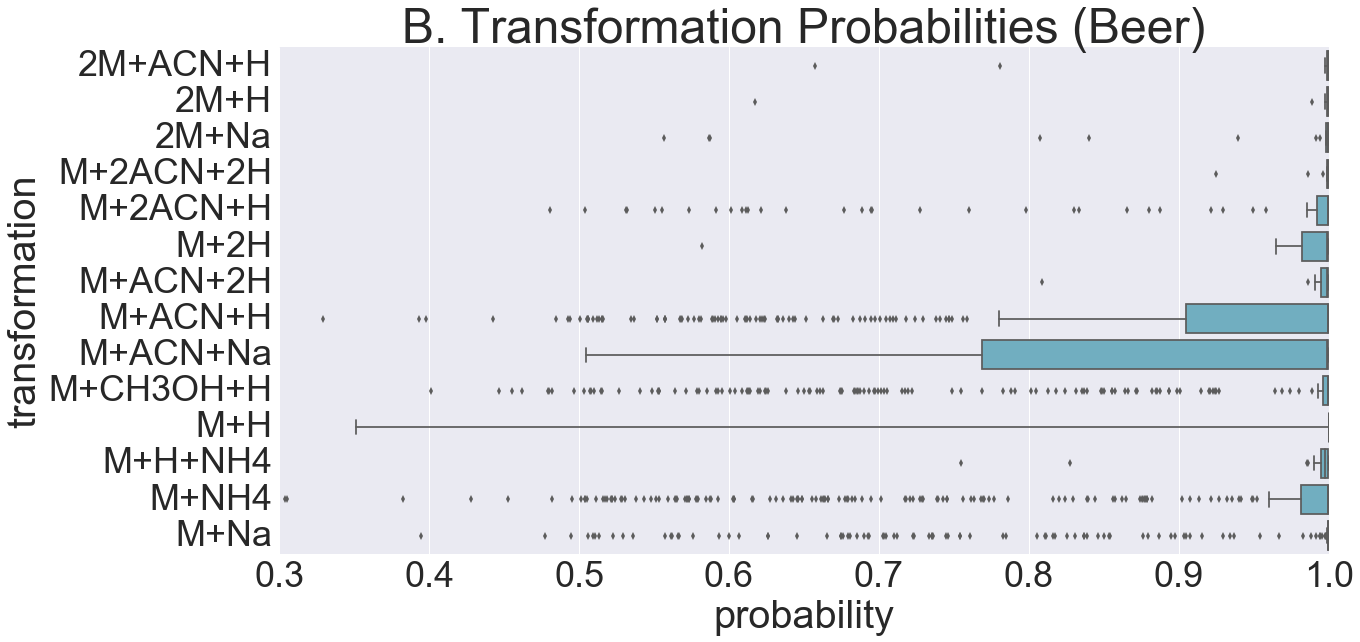

In [25]:
sns.set_context("notebook", font_scale=3.6)
df = plot_trans(aligner_beer.clustering_results, 'Beer', exclude_MH=False, size=10, aspect=2, plot=2)